In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
images_path = '/content/drive/MyDrive/data/satalite data/data/images'
masks_path = '/content/drive/MyDrive/data/satalite data/data/labels'

In [ ]:
!pip install pylibtiff

In [4]:
import cv2
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from libtiff import TIFF
import tensorflow as tf

In [16]:
from keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [8]:
img_paths = os.listdir(images_path)
mask_paths = os.listdir(masks_path)

# -> prepare data & data augmantation

In [28]:
images = []
labels = []

for img_path in img_paths:
    tiff = TIFF.open(os.path.join(images_path, img_path))
    img = tiff.read_image()
    images.append(img[:, :, 1:4]) # change number 0 to 1:4 to get the rgb version of image
    mask = plt.imread(os.path.join(masks_path, img_path.replace('.tif', '.png')))
    mask = np.where(mask > 0, 1, 0)
    labels.append(mask)

images = np.array(images)
labels = np.array(labels)

In [29]:
def augment_images_with_labels(images, labels, num_augmented_per_image=5):

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True
    )

    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):

        img = np.expand_dims(img, 0)
        label = np.expand_dims(label, 0)

        seed = np.random.randint(1e6)

        img_gen = datagen.flow(img, batch_size=1, seed=seed)
        label_gen = datagen.flow(np.expand_dims(label, axis=-1), batch_size=1, seed=seed)

        for _ in range(num_augmented_per_image):
            augmented_img = next(img_gen)[0]
            augmented_label = next(label_gen)[0].squeeze(-1)

            augmented_images.append(augmented_img)
            augmented_labels.append(augmented_label)

    all_images = np.concatenate((images, np.array(augmented_images)), axis=0)
    all_labels = np.concatenate((labels, np.array(augmented_labels)), axis=0)

    return all_images, all_labels

In [30]:
images, labels = augment_images_with_labels(images, labels)
images.shape, labels.shape

((1836, 128, 128, 3), (1836, 128, 128))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# building autoencoder model using MobilNet

In [13]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

In [18]:
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='best_model_weights.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [14]:
def encoder_model(inputs):
    base_model = applications.MobileNet(include_top=False, weights="imagenet", input_tensor=inputs)
    base_model.trainable = False
    return models.Model(inputs=base_model.input, outputs=base_model.get_layer('conv_pw_10_relu').output)

In [19]:
def decoder_model(encoder_output):
    x = encoder_output

    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(x)

    return x

def build_segmentation_model(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    encoder = encoder_model(inputs)
    decoder_output = decoder_model(encoder.output)

    model = models.Model(inputs=inputs, outputs=decoder_output)

    return model

In [20]:
input_shape = (128, 128, 3)
model = build_segmentation_model(input_shape)

<ipython-input-14-93c8dd42165b>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNet(include_top=False, weights="imagenet", input_tensor=inputs)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
model.compile(optimizer="adam", loss=dice_loss, metrics=["accuracy", dice_loss])
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[checkpoint_callback])

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.4532 - dice_loss: 0.5691 - loss: 0.5691
Epoch 1: val_accuracy improved from -inf to 0.68369, saving model to best_model_weights.weights.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 404ms/step - accuracy: 0.4557 - dice_loss: 0.5681 - loss: 0.5681 - val_accuracy: 0.6837 - val_dice_loss: 0.5551 - val_loss: 0.5534
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6791 - dice_loss: 0.4924 - loss: 0.4924
Epoch 2: val_accuracy improved from 0.68369 to 0.74485, saving model to best_model_weights.weights.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.6795 - dice_loss: 0.4919 - loss: 0.4919 - val_accuracy: 0.7449 - val_dice_loss: 0.5128 - val_loss: 0.5102
Epoch 3/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7326 - dice_loss: 0.4551 - loss: 0.4551
Epoch 3: val_accuracy did not improve from 0.74485
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7325 - dice_loss: 0.4545 - loss: 0.4545 - val_accura

# visualize model results

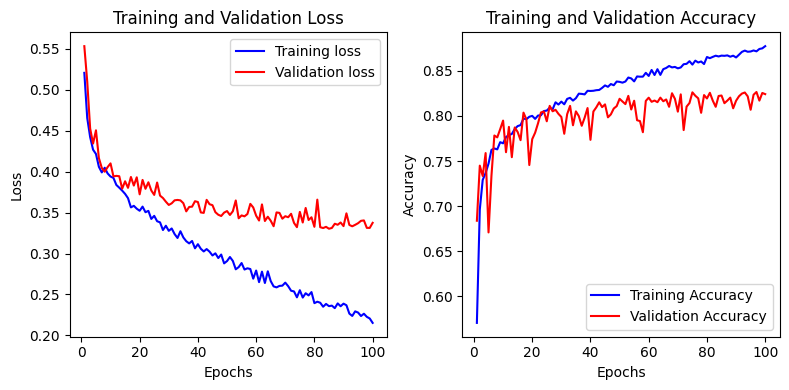

In [23]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history.get('accuracy')
val_accuracy = hist.history.get('val_accuracy')

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step


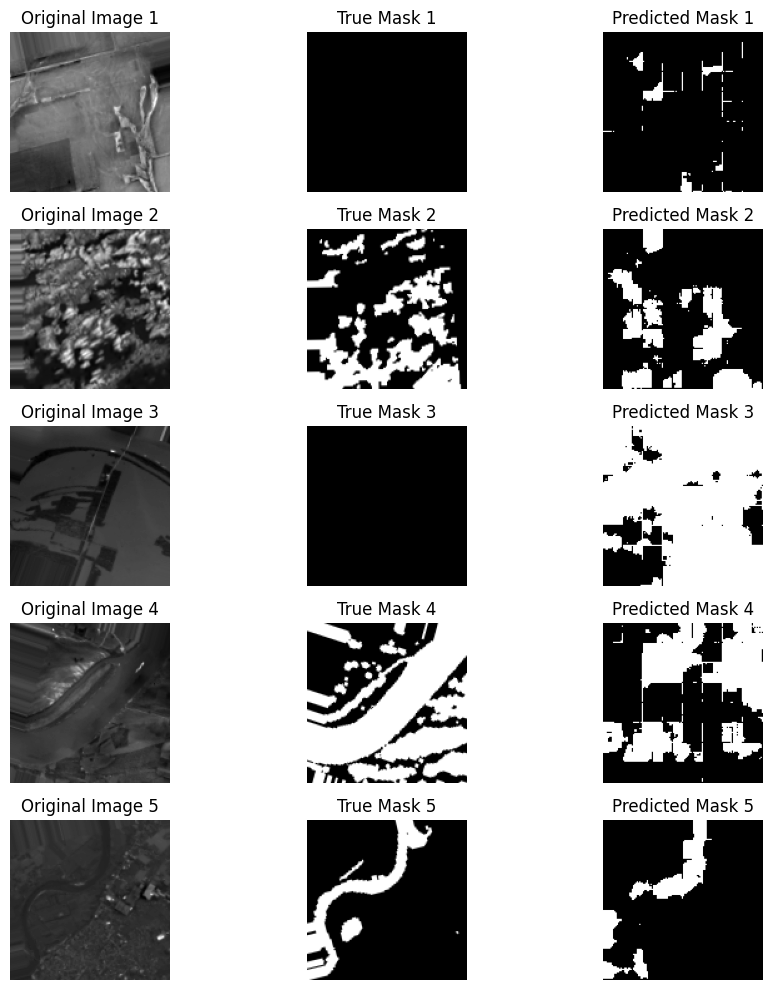

In [22]:
def show_image_mask_prediction(original_images, true_masks, predicted_masks, num_images=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_images[i][:, :, 0], cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_masks[i], cmap='gray')
        plt.title(f"True Mask {i+1}")
        plt.axis('off')


        # Predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(np.where(predicted_masks[i]>0.5, 1, 0), cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
show_image_mask_prediction(X_test[10:], y_test[10:], model.predict(X_test[10:]), num_images=5)

# build U-Net from scratch

In [ ]:
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = models.Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
input_shape = (128, 128, 3)
model_unet = build_unet(input_shape)

In [ ]:
model_unet.compile(optimizer="adam", loss=dice_loss, metrics=["accuracy", dice_loss])

In [ ]:
hist_unet = model_unet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.6891 - dice_loss: 0.4601 - loss: 0.4602 - val_accuracy: 0.2444 - val_dice_loss: 0.5918 - val_loss: 0.5913
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 464ms/step - accuracy: 0.8278 - dice_loss: 0.3183 - loss: 0.3183 - val_accuracy: 0.7309 - val_dice_loss: 0.7945 - val_loss: 0.7991
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 468ms/step - accuracy: 0.8153 - dice_loss: 0.3237 - loss: 0.3237 - val_accuracy: 0.6416 - val_dice_loss: 0.8087 - val_loss: 0.8055
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - accuracy: 0.8213 - dice_loss: 0.3096 - loss: 0.3096 - val_accuracy: 0.7152 - val_dice_loss: 0.8602 - val_loss: 0.8593
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 463ms/step - accuracy: 0.8473 - dice_loss: 0.2754 - loss: 0.2754 - val_accuracy: 0.8523 - val_dice_loss: 0.3156 - val_loss: 0.3104
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 467ms/step - accuracy: 0.8209 - dice_loss: 0.3041 - loss: 0.3041 - val_accuracy: 0.8680 -

# visualize results

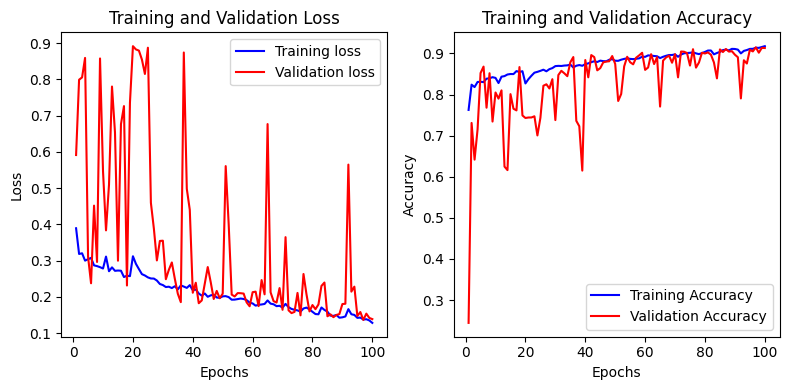

In [ ]:


loss = hist_unet.history['loss']
val_loss = hist_unet.history['val_loss']

accuracy = hist_unet.history.get('accuracy')
val_accuracy = hist_unet.history.get('val_accuracy')

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


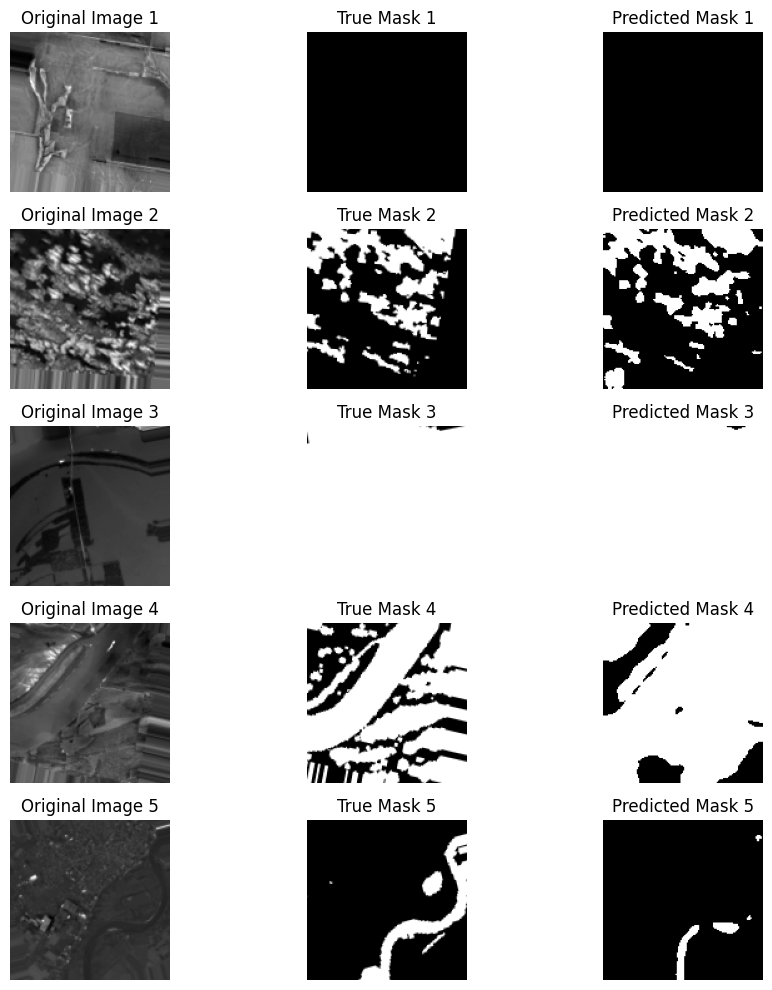

In [ ]:
show_image_mask_prediction(X_test[10:], y_test[10:], model_unet.predict(X_test[10:]), num_images=5)